c:\Users\Lab419_6\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


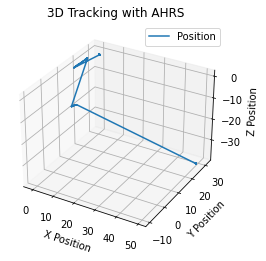

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# AHRS 클래스 정의
class AHRS:
    def __init__(self):
        self.quaternion = np.array([1, 0, 0, 0])

    def update_imu(self, gyroscope, accelerometer):
        # 자세 업데이트 로직 (현재는 빈 구현)
        pass

# KalmanAngle 클래스 정의
class KalmanAngle:
    def __init__(self):
        # 각도 추정에 대한 초기화
        self.Q_angle = 0.001  # 프로세스 노이즈 분산 (각도)
        self.Q_bias = 0.003   # 프로세스 노이즈 분산 (바이어스)
        self.R_measure = 0.03 # 측정 노이즈 분산

        self.angle = 0.0      # 초기 각도
        self.bias = 0.0       # 초기 바이어스
        self.rate = 0.0       # 초기 각속도

        # 오차 공분산 행렬
        self.P = np.zeros((2, 2))

    def getAngle(self, newAngle, newRate, dt):
        # 칼만 필터 업데이트
        # Step 1: 시간 업데이트 (예측 단계)
        self.rate = newRate - self.bias
        self.angle += dt * self.rate

        # 오차 공분산 행렬 업데이트
        self.P[0][0] += dt * (dt * self.P[1][1] - self.P[0][1] - self.P[1][0] + self.Q_angle)
        self.P[0][1] -= dt * self.P[1][1]
        self.P[1][0] -= dt * self.P[1][1]
        self.P[1][1] += self.Q_bias * dt

        # Step 2: 측정 업데이트
        y = newAngle - self.angle  # 측정 잔차
        S = self.P[0][0] + self.R_measure  # 시스템 불확실성
        K = [self.P[0][0] / S, self.P[1][0] / S]  # 칼만 이득

        self.angle += K[0] * y
        self.bias += K[1] * y

        # 오차 공분산 행렬 조정
        self.P[0][0] -= K[0] * self.P[0][0]
        self.P[0][1] -= K[0] * self.P[0][1]
        self.P[1][0] -= K[1] * self.P[0][0]
        self.P[1][1] -= K[1] * self.P[0][1]

        return self.angle

def calculate_angles(accelerometer, gyroscope):
    acc_x, acc_y, acc_z = accelerometer
    gyro_x, gyro_y, gyro_z = gyroscope

    # Roll (x축 주변 회전) 계산: arctan2(acc_y, acc_z)
    roll = np.arctan2(acc_y, acc_z)

    # Pitch (y축 주변 회전) 계산: arctan2(-acc_x, sqrt(acc_y^2 + acc_z^2))
    pitch = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))

    # Yaw (z축 주변 회전) 계산: 자이로스코프 데이터를 사용하여 적분
    # 이 예제에서는 단순화를 위해 yaw를 0으로 설정합니다.
    # 실제 구현에서는 자이로스코프 데이터를 시간에 따라 적분하여 yaw를 계산해야 합니다.
    yaw = 0

    # 각도를 라디안에서 도(degree)로 변환
    roll_degrees = np.degrees(roll)
    pitch_degrees = np.degrees(pitch)
    yaw_degrees = np.degrees(yaw)  # 현재는 항상 0

    return roll_degrees, pitch_degrees, yaw_degrees

# 데이터 로드
df = pd.read_csv('C:/Users/Lab419_6/Desktop/20192230 이동섭/IMU sensor/test/time, accl, gyro, magn, angl, vel, pos.csv')

# 위치 데이터
positions = df[['Pos_X', 'Pos_Y', 'Pos_Z']]

# 3D 트래킹 및 자세 시각화를 위한 그래프 초기화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 축에 대한 칼만 필터 인스턴스 생성
kalman_filter_x = KalmanAngle()
kalman_filter_y = KalmanAngle()
kalman_filter_z = KalmanAngle()

# 칼만 필터를 사용하여 각 축의 각도 추정
estimated_angles = []
for index, row in df.iterrows():
    gyroscope = [row['Gyro_X'], row['Gyro_Y'], row['Gyro_Z']]
    accelerometer = [row['Accl_X'], row['Accl_Y'], row['Accl_Z']]
    
    # 가속도계 데이터로부터 각도 계산
    # 예: np.arctan2 함수를 사용하여 각 축에 대한 각도를 계산
    angle_x, angle_y, angle_z = calculate_angles(accelerometer, gyroscope)

    # 칼만 필터 업데이트
    estimated_x = kalman_filter_x.getAngle(angle_x, gyroscope[0], 1/256)
    estimated_y = kalman_filter_y.getAngle(angle_y, gyroscope[1], 1/256)
    estimated_z = kalman_filter_z.getAngle(angle_z, gyroscope[2], 1/256)

    estimated_angles.append([estimated_x, estimated_y, estimated_z])

# 3D 트래킹 시각화에 추정된 각도 적용
for index, (position, angles) in enumerate(zip(positions.values, estimated_angles)):
    q = R.from_euler('xyz', angles).as_quat()
    rot = R.from_quat(q)
    vectors = rot.apply(np.eye(3))  # 단위벡터에 회전 적용
    ax.quiver(position[0], position[1], position[2], vectors[0, 0], vectors[1, 0], vectors[2, 0], length=0.1, normalize=True)


# 각도 추정 및 쿼터니언 변환
quaternions = []
for index, row in df.iterrows():
    # 각도 계산
    # 가속도계 데이터와 자이로스코프 데이터를 모두 전달
    accelerometer = [row['Accl_X'], row['Accl_Y'], row['Accl_Z']]
    gyroscope = [row['Gyro_X'], row['Gyro_Y'], row['Gyro_Z']]
    angle_x, angle_y, angle_z = calculate_angles(accelerometer, gyroscope)  # 두 데이터 모두 전달

    # 칼만 필터 업데이트
    estimated_x = kalman_filter_x.getAngle(angle_x, gyroscope[0], 1/256)
    estimated_y = kalman_filter_y.getAngle(angle_y, gyroscope[1], 1/256)
    estimated_z = kalman_filter_z.getAngle(angle_z, gyroscope[2], 1/256)

    # 쿼터니언 변환
    q = R.from_euler('xyz', [estimated_x, estimated_y, estimated_z]).as_quat()
    quaternions.append(q)

# 시각화
ax.plot(positions['Pos_X'], positions['Pos_Y'], positions['Pos_Z'], label='Position')
for position, q in zip(positions.values, quaternions):
    rot = R.from_quat(q)
    vectors = rot.apply(np.eye(3))  # 단위벡터에 회전 적용
    ax.quiver(position[0], position[1], position[2], vectors[0, 0], vectors[1, 0], vectors[2, 0], length=0.1, normalize=True)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.title('3D Tracking with AHRS')
plt.legend()
plt.show()